# PyFME Validation : comparing response with eigenvalue analysis

In [75]:
from pyfme.aircrafts import LinearB747, Cessna172, SimplifiedCessna172
from pyfme.models import EulerFlatEarth
import numpy as np
nl = np.linalg
import matplotlib.pyplot as plt
from pyfme.environment.atmosphere import ISA1976, SeaLevel
from pyfme.environment.wind import NoWind
from pyfme.environment.gravity import VerticalConstant
from pyfme.environment import Environment
from pyfme.utils.trimmer import steady_state_trim
from pyfme.models.state.position import EarthPosition
from pyfme.simulator import Simulation
from pyfme.utils.coordinates import wind2body, body2wind
from pyfme.utils.input_generator import Constant

In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We start by defining the airplane, the environment and the trim position.

In [77]:
aircraft = SimplifiedCessna172()

In [78]:
atmosphere = SeaLevel()
gravity = VerticalConstant()
wind = NoWind()
environment = Environment(atmosphere, gravity, wind)

In [79]:
pos = EarthPosition(x=0, y=0, height=1000)
psi = 0.5  # rad
TAS = 45  # m/s
controls0 = {'delta_elevator': 0, 'delta_aileron': 0, 'delta_rudder': 0, 'delta_t': 0.5}
trimmed_state, trimmed_controls = steady_state_trim(
    aircraft,
    environment,
    pos,
    psi,
    TAS,
    controls0
)
environment.update(trimmed_state)

Then we linearize the model around the trim condition. It gives us two matrices for lateral and longitudinal small perturbations.
Under the hood, the code computes dimensional stability derivatives using numerical differentiation, and then uses the analytical formulas for the linearized system given in [1].

In [80]:
system = EulerFlatEarth(t0=0, full_state=trimmed_state)

In [81]:
A_long, A_lat = system.linearized_model(trimmed_state, aircraft, environment, trimmed_controls)

In [82]:
long_val, long_vec=nl.eig(A_long)
long_val = np.expand_dims(long_val, axis = 0)
print(f"Longitudinal eigenvalues : ")
for l in long_val[0]:
    print(l)

Longitudinal eigenvalues : 
(-2.87760089356+4.12505582128j)
(-2.87760089356-4.12505582128j)
(-0.03785343075+0.257120129321j)
(-0.03785343075-0.257120129321j)


As expected we find two damped oscillatory modes in the longitudinal dynamics: phugoid and short period.

In [83]:
lat_val, lat_vec=nl.eig(A_lat)
lat_val = np.expand_dims(lat_val, axis = 0)
print(f"Lateral eigenvalues : ")
for l in lat_val[0]:
    print(l)

Lateral eigenvalues : 
(-6.96516821579+0j)
(-0.204583217243+1.17359637036j)
(-0.204583217243-1.17359637036j)
(0.0324906079983+0j)


In the lateral case, we get one oscillatory mode (dutch roll), a stable rolling convergence and an unstable - but very slow - spiral mode.

# Eigenvalue trajectories

We can compute the predicted trajectories for small perturbations.

In [84]:
# helper function to go from stability to body axis
def linear_stab_2_body(long_state=np.zeros(4), lat_state=np.zeros(4), u0=0, theta0=0,alpha0=0, beta0=0):
    # velocities
    v = wind2body(np.array([long_state[0] + u0, lat_state[0], long_state[1]]), alpha=alpha0, beta=beta0)
    # Roll rates
    r = wind2body(np.array([lat_state[1], long_state[2], lat_state[2]]), alpha=alpha0, beta=beta0)
    long_stateB = np.copy(long_state)
    lat_stateB = np.copy(lat_state)
    long_stateB[0] = v[0]
    long_stateB[1] = v[2]
    long_stateB[2] = r[1]
    long_stateB[3] += theta0
    lat_stateB[0] = v[1]
    lat_stateB[1] = r[0]
    lat_stateB[2] = r[2]
    return long_stateB.real, lat_stateB.real

In [85]:
# Reference conditions
alpha = np.arctan2(trimmed_state.velocity.w, trimmed_state.velocity.u)
beta = np.arcsin(trimmed_state.velocity.v/nl.norm(trimmed_state.velocity.vel_body))
u, v, w = body2wind(trimmed_state.velocity.vel_body, alpha, 0)
theta0 = trimmed_state.attitude.theta*1.0

## Longitudinal case

We can pick any perturbation from the equilibrium. Here I chose something along the eigenvectors of A_long.
The result will be a weighted sum of eigenvector*exp(eigenvalue*t). The weights are determined by the initial condition.

In [86]:
long_perturbation = (long_vec.T[2] + long_vec.T[3])/1000

In [87]:
C = nl.lstsq(a=long_vec,b=long_perturbation.real)[0].real

In [88]:
T = 100;
t_long = np.linspace(0,T,1000)
N = len(t_long)
X_long = np.zeros((N,4))
for i in range(N):
    x_stab = (long_vec*np.exp(long_val*t_long[i])).dot(C)
    X_long[i,:] = linear_stab_2_body(long_state=x_stab.real, alpha0=alpha, u0=u, theta0 = theta0)[0]

## Lateral case

Again we can pick any perturbation

In [89]:
lat_perturbation = (lat_vec.T[0])

In [90]:
C = nl.lstsq(a=lat_vec,b=lat_perturbation.real)[0].real

In [91]:
t_lat = np.linspace(0,10,100)
N = len(t_lat)
X_lat = np.zeros((N,4))
for i in range(N):
    x_stab = (lat_vec*np.exp(lat_val*t_lat[i])).dot(C)
    X_lat[i,:] = linear_stab_2_body(lat_state=x_stab.real, beta0=beta, alpha0=alpha, u0=u, theta0 = theta0)[1]

# Simulation

In [92]:
controls = {
    'delta_elevator': Constant(trimmed_controls['delta_elevator']),
    'delta_aileron': Constant(trimmed_controls['delta_aileron']),
    'delta_rudder': Constant(trimmed_controls['delta_rudder']),
    'delta_t': Constant(trimmed_controls['delta_t'])
}

## Longitudinal case

We perturbate the trimmed state and run the simulation

In [93]:
# Perturbate the trimmed state
trimmed_state.cancel_perturbation()
p = linear_stab_2_body(long_state=long_perturbation.real, alpha0=alpha)[0]
trimmed_state.perturbate(np.array([p[0],0,p[1]]), 'velocity')
trimmed_state.perturbate(np.array([0,p[2],0]), 'angular_vel')
trimmed_state.perturbate(np.array([p[3],0,0]), 'attitude') # /!\ Convention theta, phi, psi

In [94]:
trimmed_state.save_to_json('long_perturb.json')

In [95]:
environment.update(trimmed_state)
system = EulerFlatEarth(t0=0, full_state=trimmed_state)
sim = Simulation(aircraft, system, environment, controls)

In [96]:
r_long = sim.propagate(100)


time:   0%|                                                                                    | 0/100 [00:00<?, ?it/s]
time:   0%|                                                                         | 0.08/100 [00:00<02:07,  1.28s/it]
time:   0%|                                                          | 0.21000000000000005/100 [00:00<01:52,  1.13s/it]
time:   0%|▏                                                          | 0.3300000000000001/100 [00:00<01:43,  1.04s/it]
time:   0%|▎                                                         | 0.45000000000000023/100 [00:00<01:37,  1.02it/s]
time:   1%|▎                                                          | 0.5800000000000003/100 [00:00<01:32,  1.08it/s]
time:   1%|▍                                                          | 0.7200000000000004/100 [00:00<01:26,  1.14it/s]
time:   1%|▌                                                          | 0.8900000000000006/100 [00:00<01:18,  1.27it/s]
time:   1%|▋                           

time:  10%|█████▉                                                      | 9.949999999999832/100 [00:07<01:11,  1.26it/s]
time:  10%|██████                                                      | 10.07999999999983/100 [00:07<01:13,  1.23it/s]
time:  10%|██████                                                     | 10.209999999999827/100 [00:07<01:11,  1.25it/s]
time:  10%|██████                                                     | 10.359999999999824/100 [00:07<01:08,  1.31it/s]
time:  11%|██████▎                                                     | 10.53999999999982/100 [00:07<01:03,  1.40it/s]
time:  11%|██████▎                                                    | 10.709999999999816/100 [00:07<01:01,  1.46it/s]
time:  11%|██████▍                                                    | 10.859999999999813/100 [00:08<01:00,  1.46it/s]
time:  11%|██████▌                                                     | 11.00999999999981/100 [00:08<01:00,  1.46it/s]
time:  11%|██████▌                      

time:  21%|████████████▎                                              | 20.820000000000455/100 [00:14<00:50,  1.58it/s]
time:  21%|████████████▌                                               | 20.99000000000048/100 [00:14<00:49,  1.61it/s]
time:  21%|████████████▍                                              | 21.160000000000508/100 [00:15<00:50,  1.56it/s]
time:  21%|████████████▌                                              | 21.320000000000533/100 [00:15<00:52,  1.51it/s]
time:  21%|████████████▋                                              | 21.480000000000558/100 [00:15<00:51,  1.53it/s]
time:  22%|████████████▊                                              | 21.640000000000583/100 [00:15<00:51,  1.52it/s]
time:  22%|█████████████                                               | 21.80000000000061/100 [00:15<00:51,  1.53it/s]
time:  22%|████████████▉                                              | 21.960000000000633/100 [00:15<00:52,  1.48it/s]
time:  22%|█████████████▎               

time:  33%|███████████████████▌                                        | 32.68000000000207/100 [00:22<00:45,  1.47it/s]
time:  33%|███████████████████▋                                        | 32.83000000000204/100 [00:22<00:45,  1.47it/s]
time:  33%|███████████████████▊                                        | 32.98000000000201/100 [00:22<00:46,  1.43it/s]
time:  33%|███████████████████▌                                       | 33.150000000001974/100 [00:22<00:44,  1.49it/s]
time:  33%|████████████████████                                        | 33.36000000000193/100 [00:22<00:41,  1.62it/s]
time:  34%|███████████████████▊                                       | 33.540000000001896/100 [00:22<00:39,  1.67it/s]
time:  34%|████████████████████▏                                       | 33.74000000000186/100 [00:22<00:38,  1.72it/s]
time:  34%|████████████████████▎                                       | 33.92000000000182/100 [00:23<00:38,  1.70it/s]
time:  34%|████████████████████         

time:  44%|██████████████████████████▏                                | 44.409999999999734/100 [00:29<00:37,  1.49it/s]
time:  45%|███████████████████████████▏                                 | 44.5899999999997/100 [00:29<00:35,  1.56it/s]
time:  45%|██████████████████████████▍                                | 44.749999999999666/100 [00:30<00:36,  1.51it/s]
time:  45%|██████████████████████████▍                                | 44.909999999999634/100 [00:30<00:37,  1.49it/s]
time:  45%|███████████████████████████▍                                 | 45.0699999999996/100 [00:30<00:36,  1.49it/s]
time:  45%|███████████████████████████▏                                | 45.22999999999957/100 [00:30<00:37,  1.46it/s]
time:  45%|███████████████████████████▏                                | 45.37999999999954/100 [00:30<00:37,  1.44it/s]
time:  46%|███████████████████████████▎                                | 45.53999999999951/100 [00:30<00:37,  1.47it/s]
time:  46%|███████████████████████████▍ 

time:  56%|█████████████████████████████████▍                          | 55.79999999999747/100 [00:37<00:29,  1.49it/s]
time:  56%|█████████████████████████████████                          | 55.959999999997436/100 [00:37<00:29,  1.47it/s]
time:  56%|█████████████████████████████████                          | 56.109999999997406/100 [00:37<00:30,  1.45it/s]
time:  56%|█████████████████████████████████▏                         | 56.269999999997374/100 [00:37<00:29,  1.49it/s]
time:  56%|█████████████████████████████████▉                          | 56.48999999999733/100 [00:37<00:26,  1.64it/s]
time:  57%|██████████████████████████████████                          | 56.67999999999729/100 [00:37<00:25,  1.71it/s]
time:  57%|█████████████████████████████████▌                         | 56.869999999997255/100 [00:37<00:24,  1.74it/s]
time:  57%|██████████████████████████████████▏                         | 57.04999999999722/100 [00:38<00:25,  1.69it/s]
time:  57%|█████████████████████████████

time:  67%|███████████████████████████████████████▉                    | 66.56999999999715/100 [00:45<00:23,  1.42it/s]
time:  67%|████████████████████████████████████████                    | 66.71999999999723/100 [00:45<00:24,  1.36it/s]
time:  67%|████████████████████████████████████████▊                    | 66.8599999999973/100 [00:45<00:24,  1.34it/s]
time:  67%|████████████████████████████████████████▏                   | 66.99999999999737/100 [00:45<00:24,  1.32it/s]
time:  67%|████████████████████████████████████████▎                   | 67.13999999999744/100 [00:45<00:25,  1.28it/s]
time:  67%|████████████████████████████████████████▍                   | 67.30999999999753/100 [00:45<00:23,  1.36it/s]
time:  68%|████████████████████████████████████████▌                   | 67.50999999999763/100 [00:45<00:21,  1.50it/s]
time:  68%|████████████████████████████████████████▌                   | 67.68999999999772/100 [00:45<00:20,  1.57it/s]
time:  68%|█████████████████████████████

time:  78%|██████████████████████████████████████████████▊             | 77.94000000000297/100 [00:52<00:14,  1.50it/s]
time:  78%|██████████████████████████████████████████████▊             | 78.11000000000305/100 [00:52<00:14,  1.55it/s]
time:  78%|██████████████████████████████████████████████▉             | 78.27000000000314/100 [00:53<00:17,  1.22it/s]
time:  78%|███████████████████████████████████████████████             | 78.41000000000321/100 [00:53<00:18,  1.15it/s]
time:  79%|███████████████████████████████████████████████             | 78.54000000000327/100 [00:53<00:18,  1.18it/s]
time:  79%|███████████████████████████████████████████████▏            | 78.69000000000335/100 [00:53<00:17,  1.25it/s]
time:  79%|███████████████████████████████████████████████▎            | 78.83000000000342/100 [00:53<00:16,  1.26it/s]
time:  79%|████████████████████████████████████████████████▏            | 78.9700000000035/100 [00:53<00:16,  1.29it/s]
time:  79%|█████████████████████████████

time:  87%|████████████████████████████████████████████████████▍       | 87.43000000000782/100 [01:01<00:16,  1.32s/it]
time:  88%|████████████████████████████████████████████████████▌       | 87.51000000000786/100 [01:01<00:17,  1.39s/it]
time:  88%|████████████████████████████████████████████████████▌       | 87.60000000000791/100 [01:01<00:16,  1.33s/it]
time:  88%|████████████████████████████████████████████████████▌       | 87.69000000000796/100 [01:01<00:15,  1.27s/it]
time:  88%|██████████████████████████████████████████████████████▍       | 87.780000000008/100 [01:01<00:14,  1.22s/it]
time:  88%|████████████████████████████████████████████████████▋       | 87.88000000000805/100 [01:01<00:14,  1.17s/it]
time:  88%|█████████████████████████████████████████████████████▋       | 87.9700000000081/100 [01:01<00:14,  1.20s/it]
time:  88%|████████████████████████████████████████████████████▊       | 88.07000000000815/100 [01:01<00:13,  1.17s/it]
time:  88%|█████████████████████████████

time:  97%|██████████████████████████████████████████████████████████▎ | 97.11000000001277/100 [01:08<00:01,  1.47it/s]
time:  97%|██████████████████████████████████████████████████████████▎ | 97.27000000001286/100 [01:09<00:01,  1.39it/s]
time:  97%|██████████████████████████████████████████████████████████▍ | 97.42000000001293/100 [01:09<00:01,  1.40it/s]
time:  98%|██████████████████████████████████████████████████████████▌ | 97.59000000001302/100 [01:09<00:01,  1.46it/s]
time:  98%|███████████████████████████████████████████████████████████▌ | 97.7400000000131/100 [01:09<00:01,  1.46it/s]
time:  98%|██████████████████████████████████████████████████████████▋ | 97.89000000001317/100 [01:09<00:01,  1.45it/s]
time:  98%|██████████████████████████████████████████████████████████▊ | 98.06000000001326/100 [01:09<00:01,  1.51it/s]
time:  98%|██████████████████████████████████████████████████████████▉ | 98.22000000001334/100 [01:09<00:01,  1.48it/s]
time:  98%|█████████████████████████████

In [97]:
trimmed_state.cancel_perturbation();

## Lateral case

In [98]:
# Perturbate the trimmed state
trimmed_state.cancel_perturbation()
p = linear_stab_2_body(lat_state=lat_perturbation.real, alpha0=alpha, beta0=beta)[1]
trimmed_state.perturbate(np.array([0,p[0],0]), 'velocity')
trimmed_state.perturbate(np.array([p[1],0,p[2]]), 'angular_vel')
trimmed_state.perturbate(np.array([0,p[3],0]), 'attitude') # /!\ Convention theta, phi, psi

In [99]:
environment.update(trimmed_state)
system = EulerFlatEarth(t0=0, full_state=trimmed_state)
sim = Simulation(aircraft, system, environment, controls)

In [100]:
r_lat = sim.propagate(10)


time:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]
time:   1%|▊                                                          | 0.12999999999999998/10 [00:00<00:07,  1.26it/s]
time:   2%|█▍                                                         | 0.24000000000000007/10 [00:00<00:08,  1.19it/s]
time:   4%|██                                                         | 0.35000000000000014/10 [00:00<00:08,  1.16it/s]
time:   5%|██▊                                                        | 0.48000000000000026/10 [00:00<00:07,  1.19it/s]
time:   6%|███▋                                                        | 0.6200000000000003/10 [00:00<00:07,  1.24it/s]
time:   7%|████▍                                                       | 0.7300000000000004/10 [00:00<00:08,  1.09it/s]
time:   9%|█████▏                                                      | 0.8600000000000005/10 [00:00<00:08,  1.12it/s]
time:  10%|█████▉                      

time:  86%|█████████████████████████████████████████████████████▍        | 8.61999999999986/10 [00:08<00:01,  1.04s/it]
time:  87%|█████████████████████████████████████████████████████▎       | 8.729999999999858/10 [00:08<00:01,  1.06s/it]
time:  88%|█████████████████████████████████████████████████████▉       | 8.839999999999856/10 [00:08<00:01,  1.04s/it]
time:  90%|██████████████████████████████████████████████████████▊      | 8.979999999999853/10 [00:08<00:00,  1.06it/s]
time:  92%|███████████████████████████████████████████████████████▉     | 9.169999999999849/10 [00:09<00:00,  1.22it/s]
time:  93%|████████████████████████████████████████████████████████▊    | 9.319999999999846/10 [00:09<00:00,  1.28it/s]
time:  95%|█████████████████████████████████████████████████████████▋   | 9.459999999999843/10 [00:09<00:00,  1.28it/s]
time:  96%|███████████████████████████████████████████████████████████▌  | 9.59999999999984/10 [00:09<00:00,  1.27it/s]
time:  97%|█████████████████████████████

In [101]:
trimmed_state.cancel_perturbation();

# Compare outputs

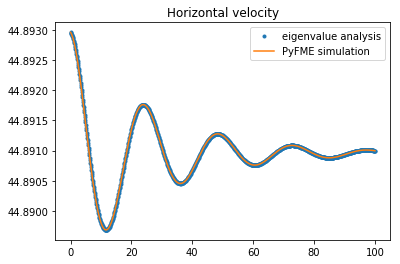

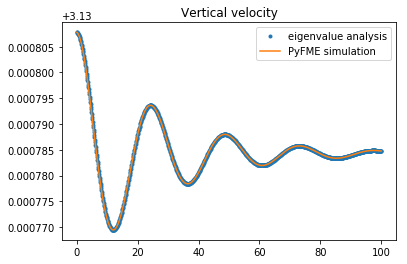

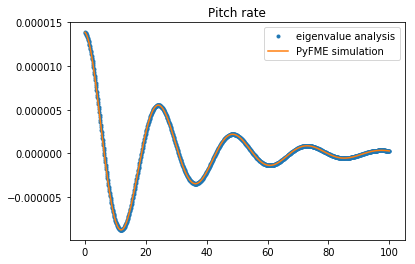

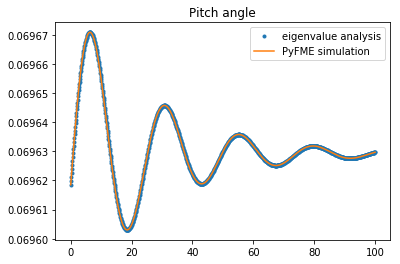

In [102]:
# Longitudinal case
plt.plot(t_long, X_long[:,0], '.', label='eigenvalue analysis')
plt.plot(r_long.u, label='PyFME simulation')
plt.legend()
plt.title("Horizontal velocity")
plt.show()

plt.plot(t_long, X_long[:,1], '.', label='eigenvalue analysis')
plt.plot(r_long.w, label='PyFME simulation')
plt.legend()
plt.title("Vertical velocity")
plt.show()

plt.plot(t_long, X_long[:,2], '.', label='eigenvalue analysis')
plt.plot(r_long.q, label='PyFME simulation')
plt.legend()
plt.title("Pitch rate")
plt.show()

plt.plot(t_long, X_long[:,3], '.', label='eigenvalue analysis')
plt.plot(r_long.theta, label='PyFME simulation')
plt.legend()
plt.title("Pitch angle")
plt.show()

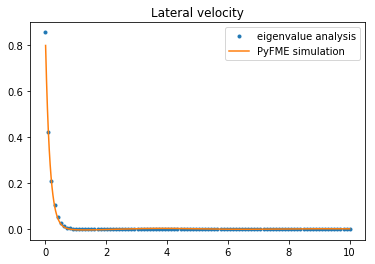

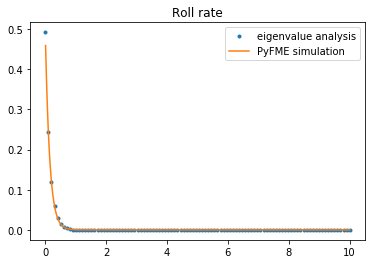

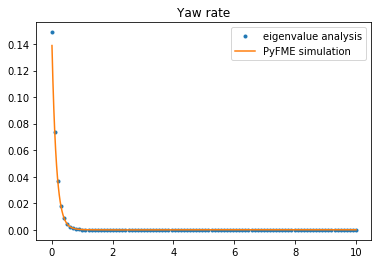

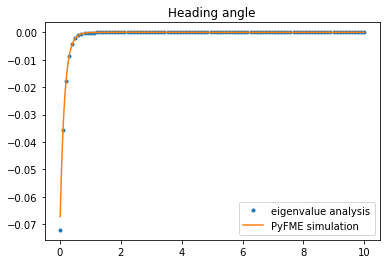

In [103]:
# Lateral case
plt.plot(t_lat, X_lat[:,0], '.', label='eigenvalue analysis')
plt.plot(r_lat.v, label='PyFME simulation')
plt.legend()
plt.title("Lateral velocity")
plt.show()

plt.plot(t_lat, X_lat[:,1], '.', label='eigenvalue analysis')
plt.plot(r_lat.p, label='PyFME simulation')
plt.legend()
plt.title("Roll rate")
plt.show()

plt.plot(t_lat, X_lat[:,2], '.', label='eigenvalue analysis')
plt.plot(r_lat.r, label='PyFME simulation')
plt.legend()
plt.title("Yaw rate")
plt.show()

plt.plot(t_lat, X_lat[:,3], '.', label='eigenvalue analysis')
plt.plot(r_lat.phi, label='PyFME simulation')
plt.legend()
plt.title("Heading angle")
plt.show()

In [105]:
aircraft.inertia


array([[ 1285.3154166 ,     0.        ,  -677.908975  ],
       [    0.        ,  1824.9309607 ,     0.        ],
       [ -677.908975  ,     0.        ,  2666.89390765]])

# References

Dynamics of Flight, Stability and Control, Etkin and Reid